In [ ]:
from tqdm import tqdm
import os

import numpy as np
import pandas as pd

import scipy.sparse  as sp

from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

모델 하이퍼파라미터



layer : 3층, batch size : 512

In [ ]:
class args:
    seed = 42
    num_layers = 3
    batch_size= 512
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    SAVE_PATH = 'Parameters'

In [ ]:
d_set = pd.read_csv('ratings.dat', sep='::', names=['user_id','business_id','stars','ts'], encoding='latin-1',header=None)
d_set = d_set.drop(columns=['ts'])

<ipython-input-3-e0068a5e4b0c>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  d_set = pd.read_csv('ratings.dat', sep='::', names=['user_id','business_id','stars','ts'], encoding='latin-1',header=None)


In [ ]:
d_train, d_test = train_test_split(d_set, train_size=0.6, random_state=args.seed)
d_valid, d_test = train_test_split(d_test, train_size=0.5, random_state=args.seed)

In [ ]:
d_train = d_train.astype({'user_id':'category', 'business_id':'category'})
d_valid = d_valid.astype({'user_id':'category', 'business_id':'category'})
d_test = d_test.astype({'user_id':'category', 'business_id':'category'})

In [ ]:
u_cat = d_train.user_id.cat.categories
b_cat = d_train.business_id.cat.categories

set_categories 통해 train data에 있는 카테고리 valid data에 생성

In [ ]:
d_valid.user_id = d_valid.user_id.cat.set_categories(u_cat)
d_valid.business_id = d_valid.business_id.cat.set_categories(b_cat)

d_test.user_id = d_test.user_id.cat.set_categories(u_cat)
d_test.business_id = d_test.business_id.cat.set_categories(b_cat)

codes 통해 user id와 item id 숫자 변환

In [ ]:
d_train.user_id = d_train.user_id.cat.codes
d_train.business_id = d_train.business_id.cat.codes

d_valid.user_id = d_valid.user_id.cat.codes
d_valid.business_id = d_valid.business_id.cat.codes

d_test.user_id = d_test.user_id.cat.codes
d_test.business_id = d_test.business_id.cat.codes

In [ ]:
d_train = d_train.dropna()
d_valid = d_valid.dropna()
d_test = d_test.dropna()

d_train.reset_index(drop=True, inplace=True)
d_valid.reset_index(drop=True, inplace=True)
d_test.reset_index(drop=True, inplace=True)

In [ ]:
d_train = d_train.astype({'user_id': int, 'business_id': int})
d_valid = d_valid.astype({'user_id': int, 'business_id': int})
d_test = d_test.astype({'user_id': int, 'business_id': int})

In [ ]:
args.num_users = d_train.user_id.max() + 1
args.num_items = d_train.business_id.max() + 1
args.latent_dim = 64
args.num_epochs = 50

torch.nn.module : PyTorch의 모든 Neural Network의 Base Class

nn.Module을 상속받아서 기본적인 기능들을 사용할 수 있게 만들어줌

Massage Passing 단계 (Message Construction 및 Message Aggregation)


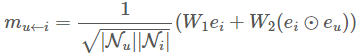


코드를 실행시킬 때에는 행렬 형태로 변환하고 계산하기 때문에 계산의 효율성 문제로 행렬로 변환
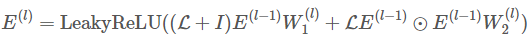


In [ ]:
class GNNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GNNLayer, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats

        self.W1 = nn.Linear(in_feats, out_feats)
        self.W2 = nn.Linear(in_feats, out_feats)

    def forward(self, L, SelfLoop, feats):
        # (L+I)EW_1
        sf_L = L + SelfLoop
        L = L.cuda()  # .cuda() -> GPU 활용
        sf_L = sf_L.cuda()
        sf_E = torch.sparse.mm(sf_L, feats)  # sparse 행렬 coo or csr 형식으로 메모리 절약, mm -> 행렬곱(matmul과 다른점은  broadcast 기능을 제공해주기 때문에 도리어 debug point가 될 수 있다.)
        left_part = self.W1(sf_E) # left part

        # EL odot EW_2, odot indicates element-wise product
        LE = torch.sparse.mm(L, feats)
        E = torch.mul(LE, feats)
        right_part = self.W2(E)

        return left_part + right_part

nn.Embedding()을 통해 user와 item embedding 생성(룩업테이블)

LaplacianMatrix

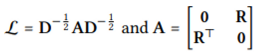

Upper Matrix는 [0, R]로 표현된 행렬의 윗 부분을 만들기 위함이고, Lower Matrix는 그 아래의 [R, 0]행렬 부분을 만들기 위함.

그 후 vstack 함수를 사용해 합친 후 Diagonal Matrix와 Adjacency Matrix를 곱해 Laplacian Matrix를 생성.


In [ ]:
class NGCF(nn.Module):
    def __init__(self, args, matrix):
        super(NGCF, self).__init__()
        self.num_users = args.num_users
        self.num_items = args.num_items
        self.latent_dim = args.latent_dim
        self.device = args.device

        self.user_emb = nn.Embedding(self.num_users, self.latent_dim)
        self.item_emb = nn.Embedding(self.num_items, self.latent_dim)

        self.num_layers = args.num_layers
        self.L = self.LaplacianMatrix(matrix)
        self.I = self.SelfLoop(self.num_users + self.num_items)

        self.leakyrelu = nn.LeakyReLU()
        self.GNNLayers = nn.ModuleList()

        for i in range(self.num_layers-1):
            self.GNNLayers.append(GNNLayer(self.latent_dim, self.latent_dim))

        self.fc_layer = nn.Sequential(
            nn.Linear(self.latent_dim * self.num_layers * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def SelfLoop(self, num):
        i = torch.LongTensor([[k for k in range(0, num)], [j for j in range(0, num)]]) # torch.LongTensor 정수형
        val = torch.FloatTensor([1]*num)
        return torch.sparse.FloatTensor(i, val)

    def LaplacianMatrix(self, ratings):
        iids = ratings['business_id'] + self.num_users
        matrix = sp.coo_matrix((ratings['stars'], (ratings['user_id'], ratings['business_id'])))

        upper_matrix = sp.coo_matrix((ratings['stars'], (ratings['user_id'], iids)))
        lower_matrix = matrix.transpose()
        lower_matrix.resize((self.num_items, self.num_users + self.num_items))

        A = sp.vstack([upper_matrix, lower_matrix])
        row_sum = (A > 0).sum(axis=1)
        # row_sum = np.array(row_sum).flatten()
        diag = list(np.array(row_sum.flatten())[0])
        D = np.power(diag, -0.5)
        D = sp.diags(D)
        L = D * A * D
        L = sp.coo_matrix(L)
        row = L.row
        col = L.col
        idx = np.stack([row, col])
        idx = torch.LongTensor(idx)
        data = torch.FloatTensor(L.data)
        SparseL = torch.sparse.FloatTensor(idx, data)
        return SparseL

    def FeatureMatrix(self):
        uids = torch.LongTensor([i for i in range(self.num_users)]).to(self.device)
        iids = torch.LongTensor([i for i in range(self.num_items)]).to(self.device)
        user_emb = self.user_emb(uids)
        item_emb = self.item_emb(iids)
        features = torch.cat([user_emb, item_emb], dim=0)  # torch.cat으로 텐서 user_emb과 item_emb 쌓음
        return features

    def forward(self, uids, iids):
        iids = self.num_users + iids

        features = self.FeatureMatrix()
        final_emb = features.clone()

        for gnn in self.GNNLayers:
            features = gnn(self.L, self.I, features)
            features = self.leakyrelu(features)
            final_emb = torch.concat([final_emb, features],dim=-1)

        user_emb = final_emb[uids]
        item_emb = final_emb[iids]

        inputs = torch.concat([user_emb, item_emb], dim=-1)
        outs = self.fc_layer(inputs)
        return outs.flatten()

DataLoader

GraphDataset이라는 클래스로 user, item, rating 데이터의 길이와 인덱스를 지정해줌

In [ ]:
class GraphDataset(Dataset):
    def __init__(self, dataframe):
        super(Dataset, self).__init__()

        self.uid = list(dataframe['user_id'])
        self.iid = list(dataframe['business_id'])
        self.ratings = list(dataframe['stars'])

    def __len__(self):
        return len(self.uid)

    def __getitem__(self, idx):
        uid = self.uid[idx]
        iid = self.iid[idx]
        rating = self.ratings[idx]

        return (uid, iid, rating)

DataLoader 통해서 batch size, num_workers 지정

In [ ]:
def get_loader(args, dataset, num_workers):
    d_set = GraphDataset(dataset)
    return DataLoader(d_set, batch_size=args.batch_size, num_workers=num_workers)

In [ ]:
train_loader = get_loader(args, d_train, 4)
valid_loader = get_loader(args, d_valid, 4)
test_loader = get_loader(args, d_test, 4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


미니배치 구성하여 L1 loss(criterion = nn.L1Loss())로 손실함수 -> 논문에서는 implict data라 bpr loss를 활용하였지만 MovieLens1M 데이터셋으로 explict한 관점에서 성능 비교하고자 L1 loss 활용.

optimizer는 Adam



---


-> 논문에서는 손실함수로 BPR loss를 활용!

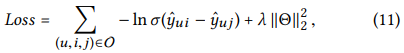

image.png
```
#  dgl 라이브러리 활용한 ngcf 코드에서 BPR LOSS 함수 활용 예)

def create_bpr_loss(self, users, pos_items, neg_items):
    pos_scores = (users * pos_items).sum(1)
    neg_scores = (users * neg_items).sum(1)

    mf_loss = nn.LogSigmoid()(pos_scores - neg_scores).mean()
    mf_loss = -1 * mf_loss

    regularizer = (
        torch.norm(users) ** 2
        + torch.norm(pos_items) ** 2
        + torch.norm(neg_items) ** 2
    ) / 2
    emb_loss = self.lmbd * regularizer / users.shape[0]

    return mf_loss + emb_loss, mf_loss, emb_loss

def rating(self, u_g_embeddings, pos_i_g_embeddings):
    return torch.matmul(u_g_embeddings, pos_i_g_embeddings.t())

def forward(self, g, user_key, item_key, users, pos_items, neg_items):
    h_dict = {ntype: self.feature_dict[ntype] for ntype in g.ntypes}
    # obtain features of each layer and concatenate them all
    user_embeds = []
    item_embeds = []
    user_embeds.append(h_dict[user_key])
    item_embeds.append(h_dict[item_key])
    for layer in self.layers:
        h_dict = layer(g, h_dict)
        user_embeds.append(h_dict[user_key])
        item_embeds.append(h_dict[item_key])
    user_embd = torch.cat(user_embeds, 1)
    item_embd = torch.cat(item_embeds, 1)

    u_g_embeddings = user_embd[users, :]
    pos_i_g_embeddings = item_embd[pos_items, :]
    neg_i_g_embeddings = item_embd[neg_items, :]

    return u_g_embeddings, pos_i_g_embeddings,
```
positive item & negative item sampling(dgl 라이브러리 활용한 ngcf 코드)



```
def sample_pos_items_for_u(u, num):
    # sample num pos items for u-th user
    pos_items = self.train_items[u]
    n_pos_items = len(pos_items)
    pos_batch = []
    while True:
        if len(pos_batch) == num:
            break
        pos_id = np.random.randint(low=0, high=n_pos_items, size=1)[0]
        pos_i_id = pos_items[pos_id]

        if pos_i_id not in pos_batch:
            pos_batch.append(pos_i_id)
    return pos_batch

def sample_neg_items_for_u(u, num):
    # sample num neg items for u-th user
    neg_items = []
    while True:
        if len(neg_items) == num:
            break
        neg_id = np.random.randint(low=0, high=self.n_items, size=1)[0]
        if (
            neg_id not in self.train_items[u]
            and neg_id not in neg_items
        ):
            neg_items.append(neg_id)
    return neg_items

pos_items, neg_items = [], []
for u in users:
    pos_items += sample_pos_items_for_u(u, 1)
    neg_items += sample_neg_items_for_u(u, 1)

return users, pos_items, neg_items
```
출처 : https://github.com/dmlc/dgl/tree/master/examples/pytorch/NGCF




In [ ]:
def graph_evaluate(args, model, test_loader, criterion):
    output = []
    test_loss = 0

    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='evaluating...'):
            batch = tuple(b.to(args.device) for b in batch)
            inputs = {'uids':   batch[0],
                      'iids':   batch[1]}
            gold_y = batch[2].float()

            pred_y = model(**inputs)
            output.append(pred_y)

            loss = criterion(pred_y, gold_y)
            loss = torch.sqrt(loss)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    return test_loss, output

In [ ]:
def graph_train(args, model, train_loader, valid_loader, optimizer, criterion):
    best_loss = float('inf')
    train_losses, valid_losses = [], []
    for epoch in range(1, args.num_epochs + 1):
        train_loss = 0.0

        model.train()
        for batch in tqdm(train_loader, desc='training...'):
            batch = tuple(b.to(args.device) for b in batch)
            inputs = {'uids':   batch[0],
                      'iids':   batch[1]}

            gold_y = batch[2].float()


            pred_y = model(**inputs)

            loss = criterion(pred_y, gold_y)
            loss = torch.sqrt(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        valid_loss , outputs = graph_evaluate(args, model, valid_loader, criterion)
        valid_losses.append(valid_loss)


        print(f'Epoch: [{epoch}/{args.num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}\tValid Loss: {valid_loss:.4f}')

        if best_loss > valid_loss:
            best_loss = valid_loss
            if not os.path.exists(args.SAVE_PATH):
                os.makedirs(args.SAVE_PATH)
            torch.save(model.state_dict(), os.path.join(args.SAVE_PATH, f'{model._get_name()}_parameters.pt'))

    return {
        'train_loss': train_losses,
        'valid_loss': valid_losses
    }, outputs

In [ ]:
models = NGCF(args, d_train).to(args.device)

optimizer = optim.Adam(models.parameters(), lr = 1e-3)
criterion = nn.L1Loss()

In [ ]:
results = graph_train(args, models, train_loader, valid_loader, optimizer, criterion)

evaluating...: 100%|██████████| 391/391 [00:56<00:00,  6.95it/s]


Epoch: [1/50]
Train Loss: 0.8882	Valid Loss: 0.8609


evaluating...: 100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


Epoch: [2/50]
Train Loss: 0.8520	Valid Loss: 0.8505


evaluating...: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]


Epoch: [3/50]
Train Loss: 0.8439	Valid Loss: 0.8467


evaluating...: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]


Epoch: [4/50]
Train Loss: 0.8383	Valid Loss: 0.8433


evaluating...: 100%|██████████| 391/391 [00:55<00:00,  7.01it/s]


Epoch: [5/50]
Train Loss: 0.8336	Valid Loss: 0.8415


evaluating...: 100%|██████████| 391/391 [00:54<00:00,  7.21it/s]


Epoch: [6/50]
Train Loss: 0.8298	Valid Loss: 0.8408


evaluating...: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]


Epoch: [7/50]
Train Loss: 0.8263	Valid Loss: 0.8398


evaluating...: 100%|██████████| 391/391 [00:55<00:00,  7.01it/s]


Epoch: [8/50]
Train Loss: 0.8233	Valid Loss: 0.8387


evaluating...: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]


Epoch: [9/50]
Train Loss: 0.8203	Valid Loss: 0.8405


evaluating...: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]


Epoch: [10/50]
Train Loss: 0.8176	Valid Loss: 0.8404


evaluating...: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]


Epoch: [11/50]
Train Loss: 0.8152	Valid Loss: 0.8401


evaluating...: 100%|██████████| 391/391 [00:55<00:00,  6.99it/s]


Epoch: [12/50]
Train Loss: 0.8128	Valid Loss: 0.8393


evaluating...: 100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


Epoch: [13/50]
Train Loss: 0.8109	Valid Loss: 0.8388


evaluating...: 100%|██████████| 391/391 [00:58<00:00,  6.71it/s]


Epoch: [14/50]
Train Loss: 0.8087	Valid Loss: 0.8397


evaluating...: 100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


Epoch: [15/50]
Train Loss: 0.8064	Valid Loss: 0.8402


evaluating...: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]


Epoch: [16/50]
Train Loss: 0.8046	Valid Loss: 0.8407


evaluating...: 100%|██████████| 391/391 [00:55<00:00,  6.99it/s]


Epoch: [17/50]
Train Loss: 0.8025	Valid Loss: 0.8417


evaluating...: 100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


Epoch: [18/50]
Train Loss: 0.8003	Valid Loss: 0.8407


evaluating...: 100%|██████████| 391/391 [00:56<00:00,  6.96it/s]


Epoch: [19/50]
Train Loss: 0.7981	Valid Loss: 0.8414


evaluating...: 100%|██████████| 391/391 [00:55<00:00,  7.02it/s]


Epoch: [20/50]
Train Loss: 0.7959	Valid Loss: 0.8421


evaluating...: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]


Epoch: [21/50]
Train Loss: 0.7941	Valid Loss: 0.8441


evaluating...: 100%|██████████| 391/391 [00:56<00:00,  6.92it/s]


Epoch: [22/50]
Train Loss: 0.7924	Valid Loss: 0.8425


evaluating...: 100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


Epoch: [23/50]
Train Loss: 0.7905	Valid Loss: 0.8442


evaluating...: 100%|██████████| 391/391 [00:54<00:00,  7.20it/s]


Epoch: [24/50]
Train Loss: 0.7889	Valid Loss: 0.8457


evaluating...: 100%|██████████| 391/391 [00:54<00:00,  7.23it/s]


Epoch: [25/50]
Train Loss: 0.7873	Valid Loss: 0.8473


evaluating...: 100%|██████████| 391/391 [00:54<00:00,  7.24it/s]


Epoch: [26/50]
Train Loss: 0.7855	Valid Loss: 0.8481


evaluating...: 100%|██████████| 391/391 [00:55<00:00,  7.02it/s]


Epoch: [27/50]
Train Loss: 0.7834	Valid Loss: 0.8525


evaluating...: 100%|██████████| 391/391 [00:54<00:00,  7.20it/s]


Epoch: [28/50]
Train Loss: 0.7816	Valid Loss: 0.8496


evaluating...: 100%|██████████| 391/391 [00:53<00:00,  7.26it/s]


Epoch: [29/50]
Train Loss: 0.7796	Valid Loss: 0.8486


evaluating...: 100%|██████████| 391/391 [00:53<00:00,  7.24it/s]


Epoch: [30/50]
Train Loss: 0.7776	Valid Loss: 0.8522


evaluating...: 100%|██████████| 391/391 [00:53<00:00,  7.25it/s]


Epoch: [31/50]
Train Loss: 0.7765	Valid Loss: 0.8519


evaluating...: 100%|██████████| 391/391 [00:54<00:00,  7.19it/s]


Epoch: [32/50]
Train Loss: 0.7750	Valid Loss: 0.8518


evaluating...: 100%|██████████| 391/391 [00:54<00:00,  7.20it/s]


Epoch: [33/50]
Train Loss: 0.7739	Valid Loss: 0.8543


evaluating...: 100%|██████████| 391/391 [00:54<00:00,  7.15it/s]


Epoch: [34/50]
Train Loss: 0.7732	Valid Loss: 0.8573


evaluating...: 100%|██████████| 391/391 [00:53<00:00,  7.25it/s]


Epoch: [35/50]
Train Loss: 0.7722	Valid Loss: 0.8540


evaluating...: 100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


Epoch: [36/50]
Train Loss: 0.7702	Valid Loss: 0.8578


evaluating...: 100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


Epoch: [37/50]
Train Loss: 0.7683	Valid Loss: 0.8580


evaluating...: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]


Epoch: [38/50]
Train Loss: 0.7663	Valid Loss: 0.8611


evaluating...: 100%|██████████| 391/391 [00:56<00:00,  6.96it/s]


Epoch: [39/50]
Train Loss: 0.7648	Valid Loss: 0.8565


evaluating...: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]


Epoch: [40/50]
Train Loss: 0.7630	Valid Loss: 0.8601


evaluating...: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]


Epoch: [41/50]
Train Loss: 0.7612	Valid Loss: 0.8601


evaluating...: 100%|██████████| 391/391 [00:53<00:00,  7.26it/s]


Epoch: [42/50]
Train Loss: 0.7595	Valid Loss: 0.8604


evaluating...: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]


Epoch: [43/50]
Train Loss: 0.7581	Valid Loss: 0.8591


evaluating...: 100%|██████████| 391/391 [00:53<00:00,  7.27it/s]


Epoch: [44/50]
Train Loss: 0.7567	Valid Loss: 0.8589


evaluating...: 100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


Epoch: [45/50]
Train Loss: 0.7551	Valid Loss: 0.8593


evaluating...: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]


Epoch: [46/50]
Train Loss: 0.7540	Valid Loss: 0.8616


evaluating...: 100%|██████████| 391/391 [00:53<00:00,  7.26it/s]


Epoch: [47/50]
Train Loss: 0.7530	Valid Loss: 0.8626


evaluating...: 100%|██████████| 391/391 [00:53<00:00,  7.25it/s]


Epoch: [48/50]
Train Loss: 0.7523	Valid Loss: 0.8624


evaluating...: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]


Epoch: [49/50]
Train Loss: 0.7518	Valid Loss: 0.8663


evaluating...: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]

Epoch: [50/50]
Train Loss: 0.7520	Valid Loss: 0.8631


In [ ]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90']